### Import the required packages

In [2]:
import torch
import random
import torchvision
import numpy as np
import pandas as pd
import numpy.ma as ma
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, random_split

### Load the data and create the Train, Validation and Test datasets

In [3]:
# Used for finding the mean and std of the dataset
#mean = X_train.train_data.float().mean() / 255 # = 0.1307
#std = X_train.train_data.float().std() / 255 # = 0.3081

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

full_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

### Check the data

In [ ]:
print(f'train_dataset data shape: {train_dataset.dataset.data[train_dataset.indices].shape}')
print(f'train_dataset targets shape: {train_dataset.dataset.targets[train_dataset.indices].shape}')

print(f'val_dataset data shape: {val_dataset.dataset.data[val_dataset.indices].shape}')
print(f'val_dataset targets shape: {val_dataset.dataset.targets[val_dataset.indices].shape}')

print(f'test_dataset data shape: {test_dataset.data.shape}')
print(f'test_datset targets shape: {test_dataset.targets.shape}')

print(f'Classes: {train_dataset.dataset.classes}')

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_dataset.dataset.data[train_dataset.indices][i], cmap='gray')
    plt.xlabel(f'Label: {train_dataset.dataset.targets[train_dataset.indices][i]}')

### Check the data distribution

In [ ]:
y_train = train_dataset.dataset.targets[train_dataset.indices].numpy()
y_val = val_dataset.dataset.targets[val_dataset.indices].numpy()
y_test = test_dataset.targets.numpy()
    
datasets = {
    'Train': y_train,
    'Val': y_val,
    'Test': y_test
}
    
data = []
for set_name, y_data in datasets.items():
    unique, counts = np.unique(y_data, return_counts=True)
    for digit, count in zip(unique, counts):
        data.append({
            'Dataset': set_name,
            'Digit': digit,
            'Count': count
        })
    
df = pd.DataFrame(data)
    
plt.figure(figsize=(15, 8))
df_pivot = df.pivot(index='Digit', columns='Dataset', values='Count')
df_pivot.plot(kind='bar', width=0.8)
    
plt.title('Digit distribution in MNIST datasets')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.legend(title='Dataset', loc='upper right')
plt.grid(True, alpha=0.3)
    
plt.show()

### Model class and helper functions

In [4]:
class Net(nn.Module):
    def __init__(self, input_size, n_neurons, num_classes):
        super(Net, self).__init__()
        layers = []

        current_size = input_size

        for neurons in n_neurons:
            layers.extend([
                nn.Linear(current_size, neurons),
                nn.ReLU()
            ])
            current_size = neurons

        layers.append(nn.Linear(current_size, num_classes))

        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)
    
def create_dataloaders(dataset, batch_size, num_workers, shuffle):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=True
    )
    
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias) 

def create_model(input_size, n_neurons, num_classes, learning_rate, eta_minus, eta_plus, min_step, max_step, device):
    model = Net(input_size, n_neurons, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Rprop(
        model.parameters(),
        lr=learning_rate,
        etas=(eta_minus, eta_plus),
        step_sizes=(min_step, max_step)
    )

    model.apply(weights_init)

    return model, criterion, optimizer

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience, min_delta, verbose):
    train_losses = []
    val_losses = []
    val_accuracies = []
    patience_counter = 0
    best_val_loss = float('inf')
    best_model_state = None
    n_total_steps = len(train_loader)

    for epoch in range(num_epochs):
        
        total_train_loss = 0.0
        n_train_samples = 0

        # Training phase
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * labels.size(0)
            n_train_samples += labels.size(0)

            if verbose and (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}]')

        avg_train_loss = total_train_loss / n_train_samples
        train_losses.append(avg_train_loss)

        # Validation phase
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Early stopping check
        if best_val_loss - val_loss > min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        print(f'Epoch [{epoch+1}/{num_epochs}], Train loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return train_losses, val_losses, val_accuracies
    
def validate_model(model, val_loader, criterion, device):
    total_loss = 0.0
    n_samples = 0
    n_correct = 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            n_samples += labels.size(0)

            _, predicted = torch.max(outputs, 1)
            n_correct += (predicted == labels).sum().item()

        avg_loss = total_loss / n_samples
        accuracy = 100.0 * n_correct / n_samples
    
    return avg_loss, accuracy

def plot_results(train_losses, val_losses, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, '--', label='Train', alpha=0.7)
    ax1.plot(epochs, val_losses, '-', label='Validation')
    
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot validation accuracy
    ax2.plot(epochs, val_accuracies, label='Validation')
    
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def plot_fold_results(fold_train_losses, fold_val_losses, fold_val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    for fold_idx, (train_losses, val_losses) in enumerate(zip(fold_train_losses, fold_val_losses)):
        epochs = range(1, len(train_losses) + 1)
        ax1.plot(epochs, train_losses, '--', label=f'Fold {fold_idx+1} (Train)', alpha=0.7)
        ax1.plot(epochs, val_losses, '-', label=f'Fold {fold_idx+1} (Val)')
    
    ax1.set_title('Training and Validation Loss per Fold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot validation accuracies
    for fold_idx, acc in enumerate(fold_val_accuracies):
        epochs = range(1, len(acc) + 1)
        ax2.plot(epochs, acc, label=f'Fold {fold_idx+1}')
    
    ax2.set_title('Validation Accuracy per Fold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Model definition, training and testing (no kfold for fast evaluation)

In [ ]:
seed = 42

set_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters for the neural network
input_size = 784
n_neurons = (128, 64)
num_classes = 10

# Hyperparameters for the training
num_epochs = 300
batch_size = len(train_dataset)
learning_rate = 0.01

# Hyperparameters for the Rprop optimizer
eta_minus = 0.5
eta_plus = 1.2
min_step = 1e-6
max_step = 50

# Hyperparameters for early stopping
patience = 3
min_delta = 0.050

train_loader = create_dataloaders(train_dataset, batch_size, num_workers=8, shuffle=True)
val_loader = create_dataloaders(val_dataset, batch_size, num_workers=8, shuffle=False)
test_loader = create_dataloaders(test_dataset, batch_size, num_workers=8, shuffle=False)

model, criterion, optimizer = create_model(
    input_size, 
    n_neurons, 
    num_classes, 
    learning_rate, 
    eta_minus, 
    eta_plus, 
    min_step, 
    max_step, 
    device
)

train_losses, val_losses, val_accuracies = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    device, 
    num_epochs, 
    patience,
    min_delta, 
    verbose=True
)

plot_results(train_losses, val_losses, val_accuracies)

_, acc = validate_model(model, test_loader, criterion, device)
print(f'Test accuracy: {acc:.2f}%')

### KFold cross validation with random search


Trial 1/10
Testing parameters: {'n_neurons': (128,), 'eta_minus': 0.5, 'eta_plus': 1.4, 'min_step': 1e-05, 'max_step': 50.0}
FOLD 1/3
Epoch [1/300], Train loss: 2.9093, Val Loss: 4.6690, Val Acc: 32.70%
Epoch [2/300], Train loss: 4.6559, Val Loss: 2.8670, Val Acc: 43.77%
Epoch [3/300], Train loss: 2.8449, Val Loss: 1.3411, Val Acc: 65.22%
Epoch [4/300], Train loss: 1.3221, Val Loss: 1.5543, Val Acc: 62.44%
Epoch [5/300], Train loss: 1.5662, Val Loss: 1.1500, Val Acc: 70.61%
Epoch [6/300], Train loss: 1.1465, Val Loss: 0.5234, Val Acc: 85.24%
Epoch [7/300], Train loss: 0.5269, Val Loss: 1.4207, Val Acc: 67.19%
Epoch [8/300], Train loss: 1.4339, Val Loss: 0.9867, Val Acc: 76.68%
Epoch [9/300], Train loss: 0.9859, Val Loss: 0.5160, Val Acc: 86.08%
Early stopping triggered at epoch 9
FOLD 2/3
Epoch [1/300], Train loss: 3.0661, Val Loss: 4.4794, Val Acc: 30.36%
Epoch [2/300], Train loss: 4.4659, Val Loss: 3.3080, Val Acc: 39.16%
Epoch [3/300], Train loss: 3.2823, Val Loss: 1.7270, Val Acc:

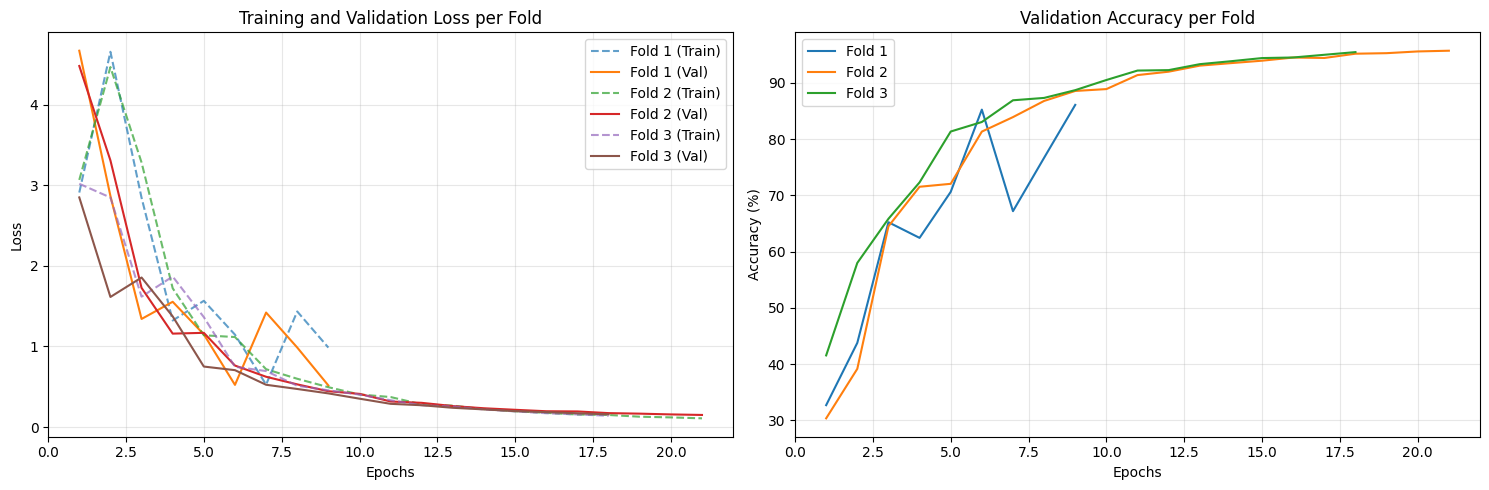


Trial 1 completed:
Parameters: {'n_neurons': (128,), 'eta_minus': 0.5, 'eta_plus': 1.4, 'min_step': 1e-05, 'max_step': 50.0}
Average accuracy across folds: 92.4172

Trial 2/10
Testing parameters: {'n_neurons': (128,), 'eta_minus': 0.7, 'eta_plus': 1.4, 'min_step': 1e-05, 'max_step': 60.0}
FOLD 1/3
Epoch [1/300], Train loss: 3.4559, Val Loss: 3.7419, Val Acc: 41.88%
Epoch [2/300], Train loss: 3.7451, Val Loss: 3.2943, Val Acc: 50.73%
Epoch [3/300], Train loss: 3.2996, Val Loss: 4.9445, Val Acc: 32.15%
Epoch [4/300], Train loss: 4.9480, Val Loss: 2.4411, Val Acc: 50.37%
Epoch [5/300], Train loss: 2.4465, Val Loss: 2.5571, Val Acc: 61.51%
Epoch [6/300], Train loss: 2.5618, Val Loss: 2.5539, Val Acc: 65.78%
Epoch [7/300], Train loss: 2.5481, Val Loss: 1.0430, Val Acc: 81.13%
Epoch [8/300], Train loss: 1.0544, Val Loss: 1.3604, Val Acc: 75.81%
Epoch [9/300], Train loss: 1.3665, Val Loss: 0.9321, Val Acc: 81.98%
Epoch [10/300], Train loss: 0.9255, Val Loss: 0.9105, Val Acc: 82.38%
Epoch [11

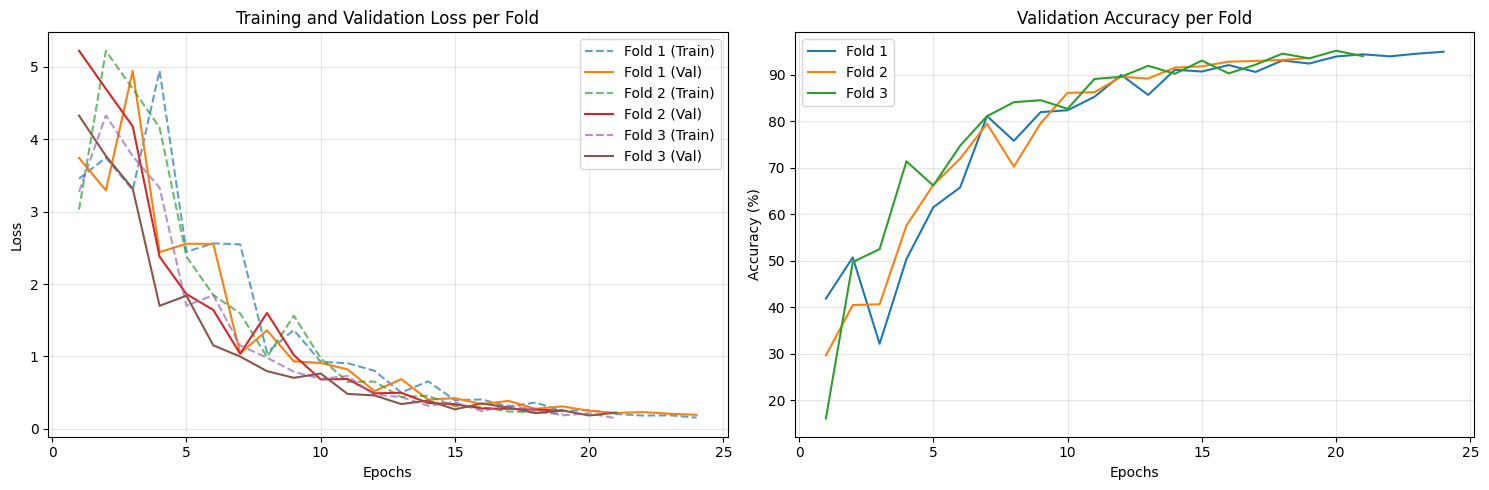


Trial 2 completed:
Parameters: {'n_neurons': (128,), 'eta_minus': 0.7, 'eta_plus': 1.4, 'min_step': 1e-05, 'max_step': 60.0}
Average accuracy across folds: 94.5857

Trial 3/10
Testing parameters: {'n_neurons': (256, 128), 'eta_minus': 0.5, 'eta_plus': 1.2, 'min_step': 1e-05, 'max_step': 50.0}
FOLD 1/3
Epoch [1/300], Train loss: 2.4805, Val Loss: 4.7226, Val Acc: 25.73%
Epoch [2/300], Train loss: 4.7144, Val Loss: 4.3569, Val Acc: 40.47%
Epoch [3/300], Train loss: 4.3669, Val Loss: 6.0530, Val Acc: 37.15%
Epoch [4/300], Train loss: 6.0637, Val Loss: 3.7678, Val Acc: 53.63%
Epoch [5/300], Train loss: 3.7495, Val Loss: 1.7998, Val Acc: 66.97%
Epoch [6/300], Train loss: 1.7938, Val Loss: 1.2226, Val Acc: 71.62%
Epoch [7/300], Train loss: 1.2147, Val Loss: 1.1918, Val Acc: 73.05%
Epoch [8/300], Train loss: 1.1812, Val Loss: 0.6380, Val Acc: 84.30%
Epoch [9/300], Train loss: 0.6319, Val Loss: 0.5501, Val Acc: 86.88%
Epoch [10/300], Train loss: 0.5431, Val Loss: 0.4544, Val Acc: 88.76%
Epoch

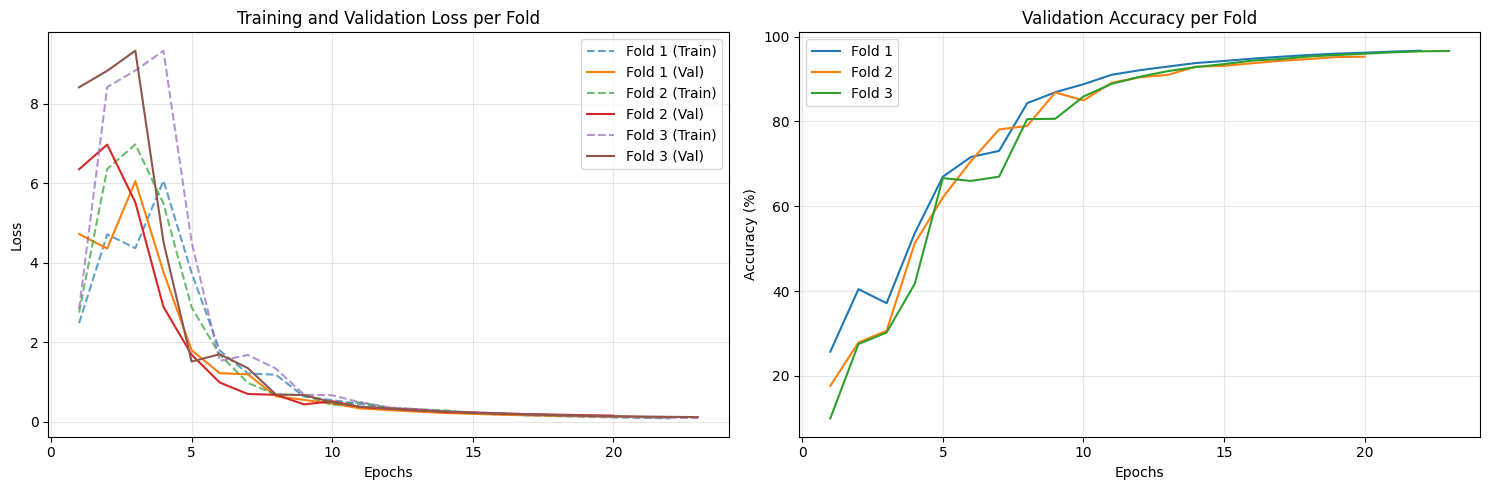


Trial 3 completed:
Parameters: {'n_neurons': (256, 128), 'eta_minus': 0.5, 'eta_plus': 1.2, 'min_step': 1e-05, 'max_step': 50.0}
Average accuracy across folds: 96.1700

Trial 4/10
Testing parameters: {'n_neurons': (128, 64), 'eta_minus': 0.7, 'eta_plus': 1.2, 'min_step': 1e-06, 'max_step': 70.0}
FOLD 1/3
Epoch [1/300], Train loss: 2.5309, Val Loss: 3.5763, Val Acc: 29.56%
Epoch [2/300], Train loss: 3.5689, Val Loss: 2.5969, Val Acc: 35.87%
Epoch [3/300], Train loss: 2.5868, Val Loss: 2.2094, Val Acc: 43.57%
Epoch [4/300], Train loss: 2.2087, Val Loss: 2.0246, Val Acc: 51.37%
Epoch [5/300], Train loss: 2.0238, Val Loss: 1.7500, Val Acc: 58.39%
Epoch [6/300], Train loss: 1.7590, Val Loss: 1.0754, Val Acc: 65.69%
Epoch [7/300], Train loss: 1.0903, Val Loss: 1.1298, Val Acc: 66.50%
Epoch [8/300], Train loss: 1.1276, Val Loss: 0.7022, Val Acc: 77.46%
Epoch [9/300], Train loss: 0.6905, Val Loss: 0.5084, Val Acc: 85.64%
Epoch [10/300], Train loss: 0.5092, Val Loss: 0.6348, Val Acc: 82.42%
Ep

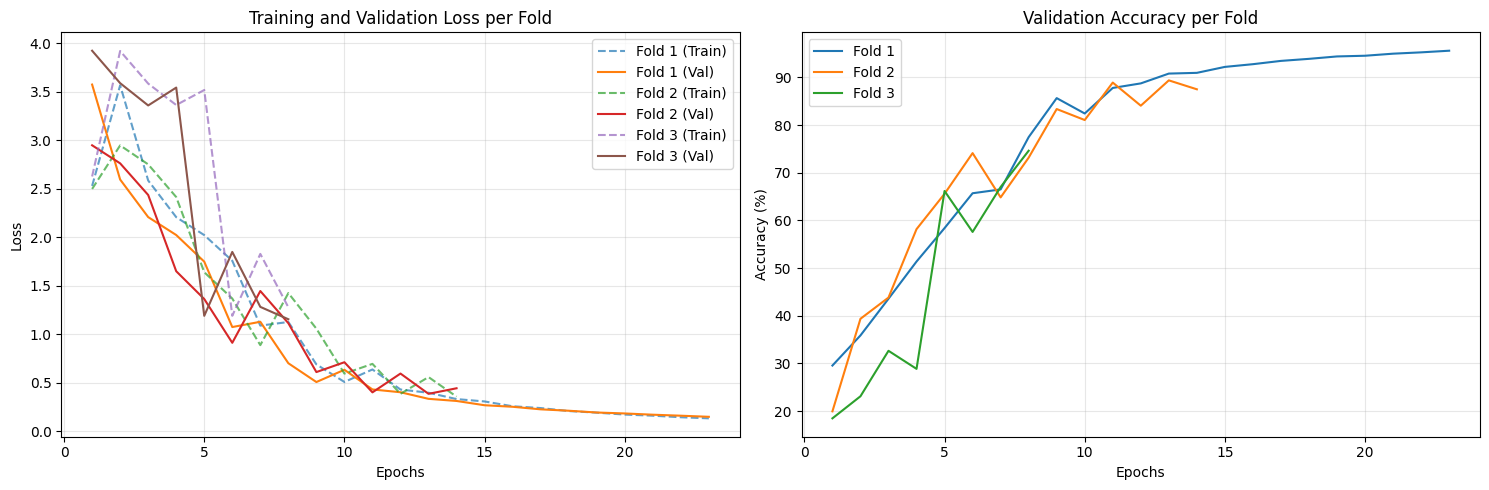


Trial 4 completed:
Parameters: {'n_neurons': (128, 64), 'eta_minus': 0.7, 'eta_plus': 1.2, 'min_step': 1e-06, 'max_step': 70.0}
Average accuracy across folds: 86.5213

Trial 5/10
Testing parameters: {'n_neurons': (128, 64), 'eta_minus': 0.6, 'eta_plus': 1.3, 'min_step': 1e-06, 'max_step': 60.0}
FOLD 1/3
Epoch [1/300], Train loss: 2.7737, Val Loss: 2.6462, Val Acc: 25.16%
Epoch [2/300], Train loss: 2.6363, Val Loss: 4.4424, Val Acc: 20.95%
Epoch [3/300], Train loss: 4.4427, Val Loss: 2.4755, Val Acc: 36.43%
Epoch [4/300], Train loss: 2.4550, Val Loss: 2.3018, Val Acc: 47.78%
Epoch [5/300], Train loss: 2.3019, Val Loss: 1.4074, Val Acc: 65.07%
Epoch [6/300], Train loss: 1.3905, Val Loss: 1.3983, Val Acc: 64.10%
Epoch [7/300], Train loss: 1.3897, Val Loss: 0.6736, Val Acc: 80.32%
Epoch [8/300], Train loss: 0.6676, Val Loss: 1.1693, Val Acc: 69.16%
Epoch [9/300], Train loss: 1.1765, Val Loss: 0.7306, Val Acc: 79.02%
Epoch [10/300], Train loss: 0.7397, Val Loss: 0.5273, Val Acc: 84.84%
Epo

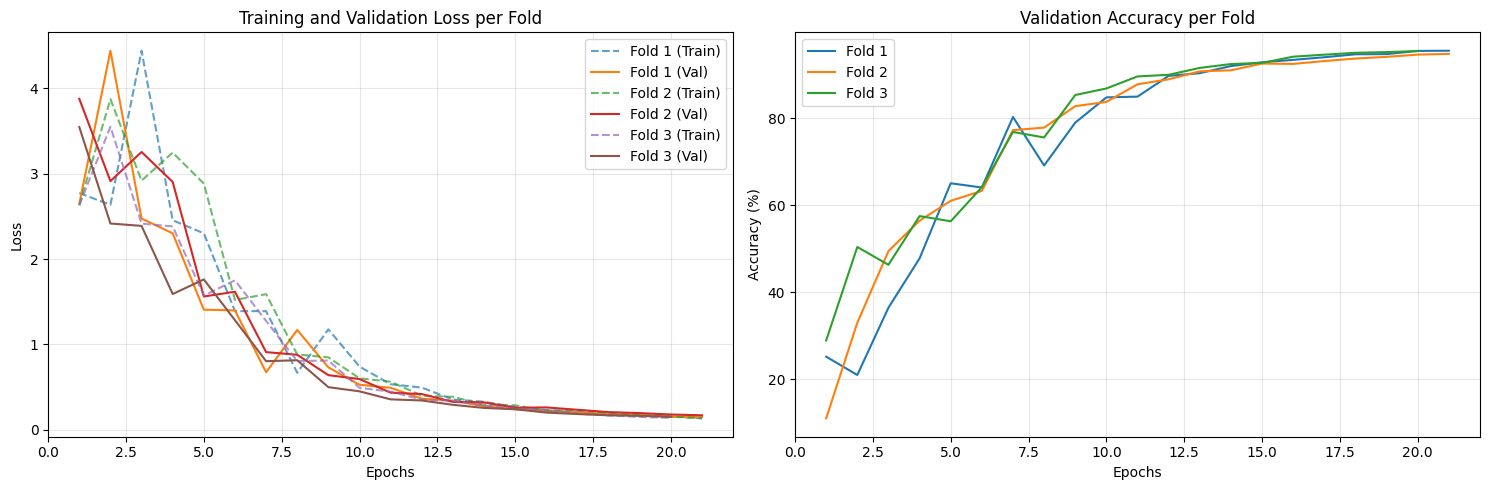


Trial 5 completed:
Parameters: {'n_neurons': (128, 64), 'eta_minus': 0.6, 'eta_plus': 1.3, 'min_step': 1e-06, 'max_step': 60.0}
Average accuracy across folds: 95.3100

Trial 6/10
Testing parameters: {'n_neurons': (128, 64), 'eta_minus': 0.7, 'eta_plus': 1.4, 'min_step': 1e-06, 'max_step': 60.0}
FOLD 1/3
Epoch [1/300], Train loss: 2.4515, Val Loss: 5.1819, Val Acc: 19.98%
Epoch [2/300], Train loss: 5.1798, Val Loss: 3.5477, Val Acc: 39.64%
Epoch [3/300], Train loss: 3.5406, Val Loss: 2.1977, Val Acc: 51.93%
Epoch [4/300], Train loss: 2.1918, Val Loss: 2.1528, Val Acc: 58.43%
Epoch [5/300], Train loss: 2.1746, Val Loss: 1.8154, Val Acc: 60.53%
Epoch [6/300], Train loss: 1.8189, Val Loss: 1.5231, Val Acc: 70.57%
Epoch [7/300], Train loss: 1.5551, Val Loss: 0.9368, Val Acc: 77.67%
Epoch [8/300], Train loss: 0.9537, Val Loss: 1.6642, Val Acc: 70.56%
Epoch [9/300], Train loss: 1.6911, Val Loss: 0.7189, Val Acc: 86.18%
Epoch [10/300], Train loss: 0.7362, Val Loss: 2.7481, Val Acc: 67.78%
Epo

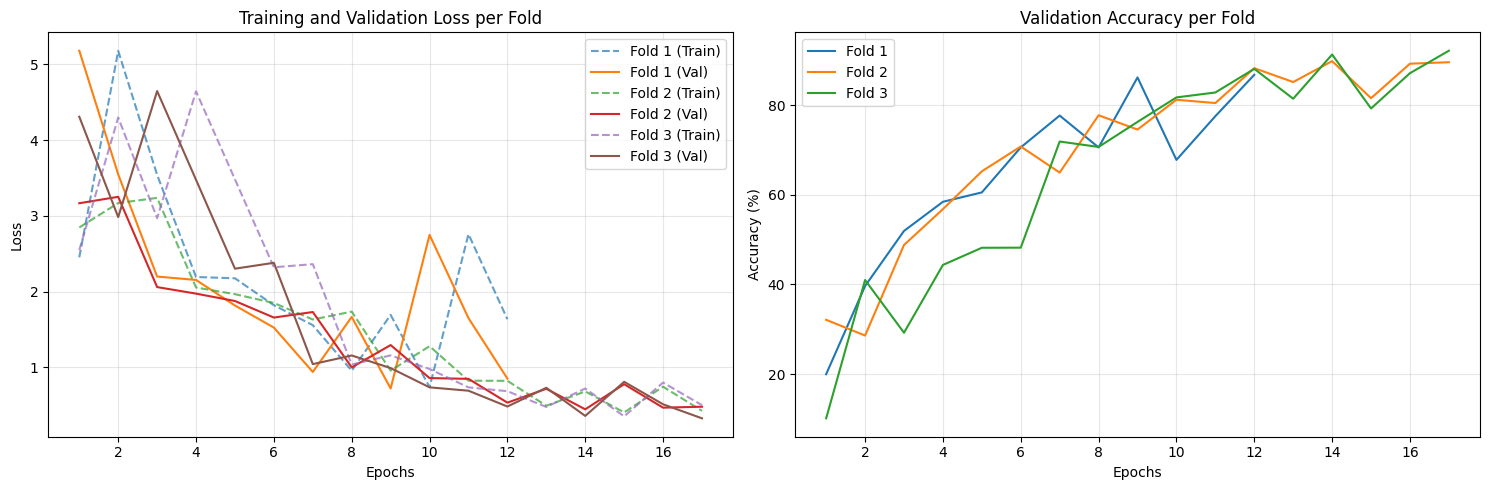


Trial 6 completed:
Parameters: {'n_neurons': (128, 64), 'eta_minus': 0.7, 'eta_plus': 1.4, 'min_step': 1e-06, 'max_step': 60.0}
Average accuracy across folds: 89.5686

Trial 7/10
Testing parameters: {'n_neurons': (128,), 'eta_minus': 0.7, 'eta_plus': 1.4, 'min_step': 1e-07, 'max_step': 50.0}
FOLD 1/3
Epoch [1/300], Train loss: 2.9335, Val Loss: 3.9786, Val Acc: 36.38%
Epoch [2/300], Train loss: 3.9687, Val Loss: 3.7272, Val Acc: 44.01%
Epoch [3/300], Train loss: 3.7162, Val Loss: 3.1085, Val Acc: 46.11%
Epoch [4/300], Train loss: 3.1263, Val Loss: 1.2895, Val Acc: 72.12%
Epoch [5/300], Train loss: 1.3063, Val Loss: 1.8740, Val Acc: 64.18%
Epoch [6/300], Train loss: 1.8800, Val Loss: 0.8271, Val Acc: 81.38%
Epoch [7/300], Train loss: 0.8240, Val Loss: 2.0313, Val Acc: 65.09%
Epoch [8/300], Train loss: 2.0560, Val Loss: 0.9947, Val Acc: 79.91%
Epoch [9/300], Train loss: 1.0085, Val Loss: 1.2971, Val Acc: 76.25%
Early stopping triggered at epoch 9
FOLD 2/3
Epoch [1/300], Train loss: 2.73

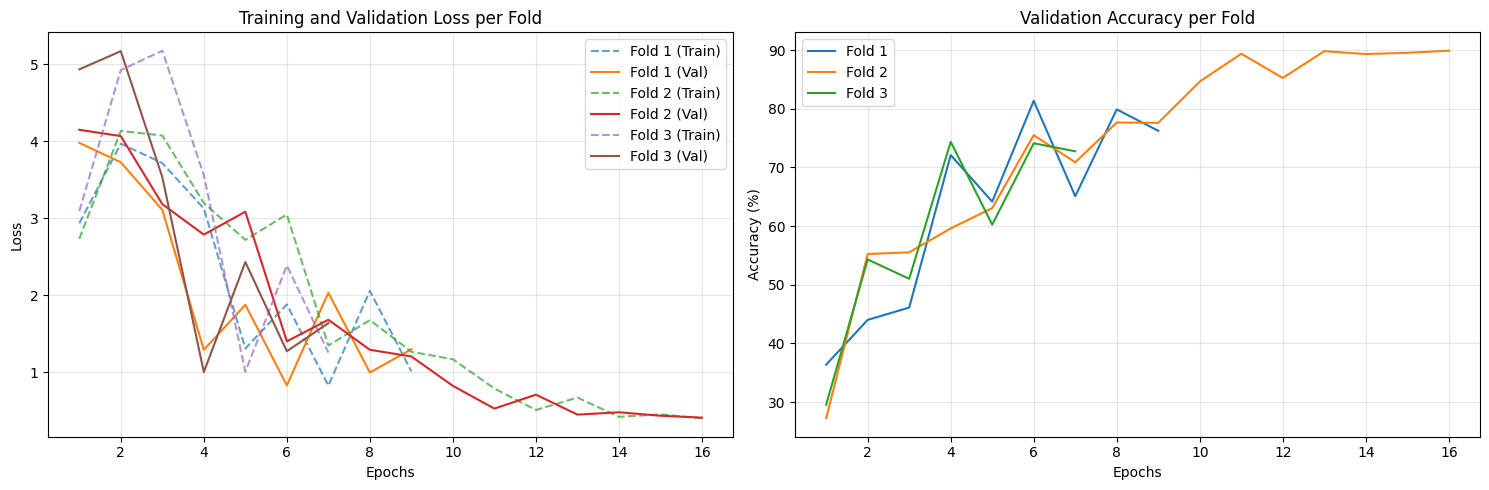


Trial 7 completed:
Parameters: {'n_neurons': (128,), 'eta_minus': 0.7, 'eta_plus': 1.4, 'min_step': 1e-07, 'max_step': 50.0}
Average accuracy across folds: 81.8914

Trial 8/10
Testing parameters: {'n_neurons': (512, 256), 'eta_minus': 0.5, 'eta_plus': 1.2, 'min_step': 1e-06, 'max_step': 50.0}
FOLD 1/3
Epoch [1/300], Train loss: 2.4563, Val Loss: 13.3348, Val Acc: 22.38%
Epoch [2/300], Train loss: 13.2833, Val Loss: 16.0610, Val Acc: 29.26%
Epoch [3/300], Train loss: 16.0845, Val Loss: 9.8054, Val Acc: 38.61%
Epoch [4/300], Train loss: 9.7956, Val Loss: 3.6022, Val Acc: 58.22%
Epoch [5/300], Train loss: 3.5749, Val Loss: 4.0602, Val Acc: 56.18%
Epoch [6/300], Train loss: 4.0239, Val Loss: 2.4493, Val Acc: 68.55%
Epoch [7/300], Train loss: 2.4373, Val Loss: 1.1110, Val Acc: 81.38%
Epoch [8/300], Train loss: 1.1388, Val Loss: 0.7613, Val Acc: 85.59%
Epoch [9/300], Train loss: 0.7786, Val Loss: 0.7303, Val Acc: 85.50%
Epoch [10/300], Train loss: 0.7169, Val Loss: 0.4760, Val Acc: 90.01%
E

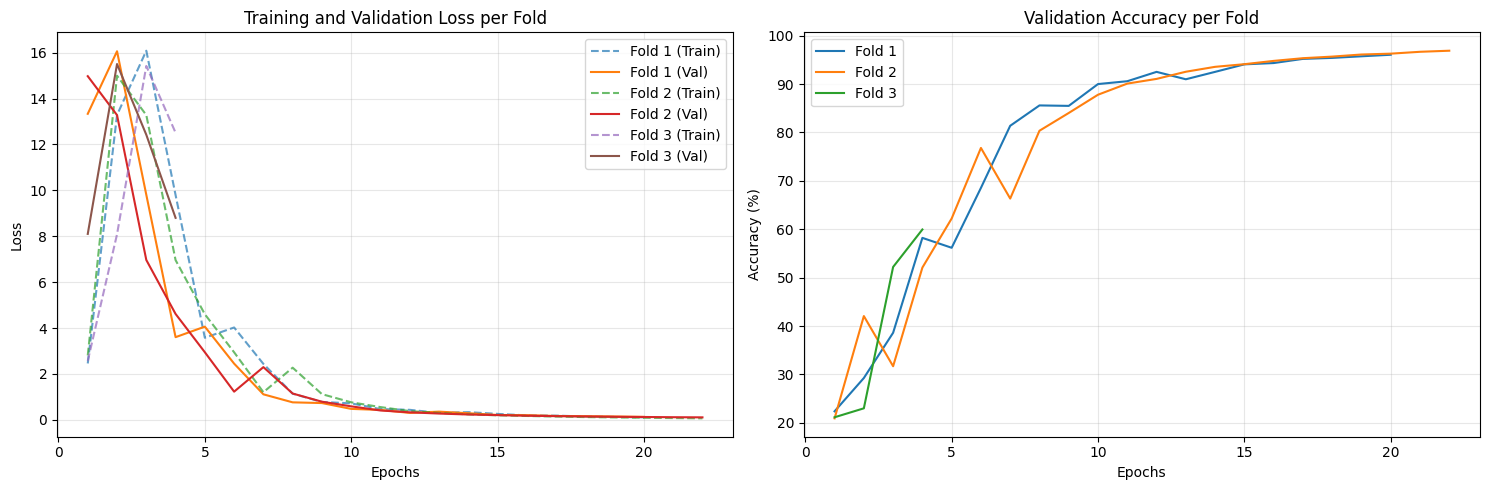


Trial 8 completed:
Parameters: {'n_neurons': (512, 256), 'eta_minus': 0.5, 'eta_plus': 1.2, 'min_step': 1e-06, 'max_step': 50.0}
Average accuracy across folds: 84.3041

Trial 9/10
Testing parameters: {'n_neurons': (128,), 'eta_minus': 0.6, 'eta_plus': 1.3, 'min_step': 1e-05, 'max_step': 60.0}
FOLD 1/3
Epoch [1/300], Train loss: 2.8992, Val Loss: 4.8195, Val Acc: 24.01%
Epoch [2/300], Train loss: 4.8384, Val Loss: 4.3307, Val Acc: 38.83%
Epoch [3/300], Train loss: 4.3299, Val Loss: 2.5282, Val Acc: 58.16%
Epoch [4/300], Train loss: 2.4938, Val Loss: 1.9350, Val Acc: 62.35%
Epoch [5/300], Train loss: 1.9132, Val Loss: 1.3301, Val Acc: 69.61%
Epoch [6/300], Train loss: 1.3361, Val Loss: 0.8905, Val Acc: 77.65%
Epoch [7/300], Train loss: 0.8941, Val Loss: 0.8635, Val Acc: 80.32%
Epoch [8/300], Train loss: 0.8562, Val Loss: 0.5303, Val Acc: 86.33%
Epoch [9/300], Train loss: 0.5292, Val Loss: 0.6487, Val Acc: 83.27%
Epoch [10/300], Train loss: 0.6583, Val Loss: 0.5732, Val Acc: 84.80%
Epoch

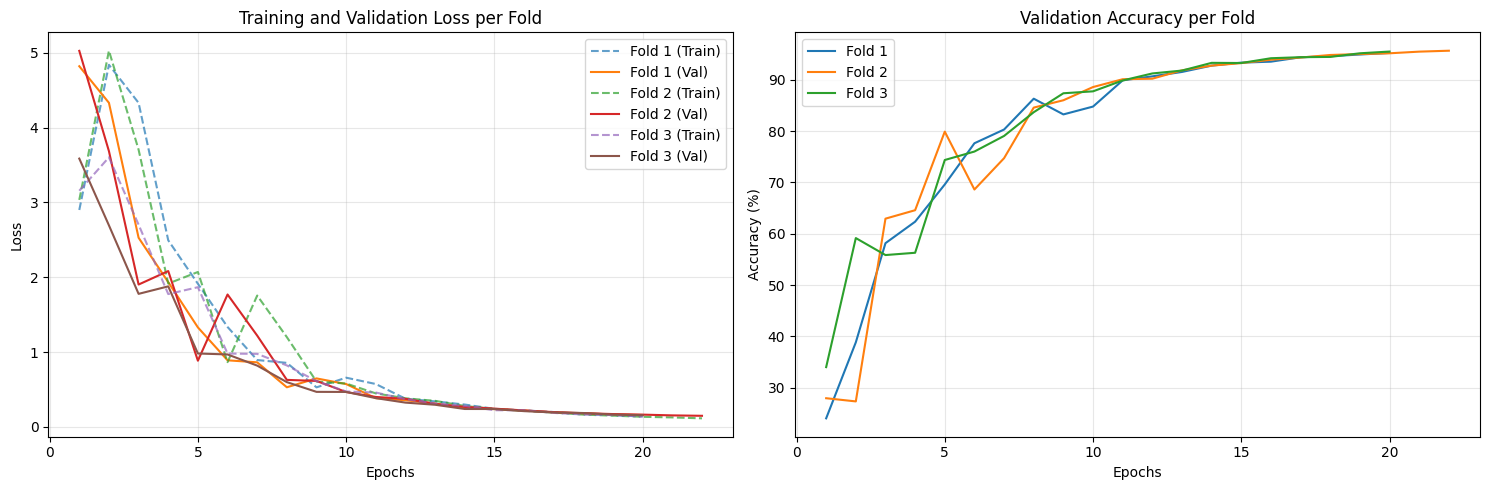


Trial 9 completed:
Parameters: {'n_neurons': (128,), 'eta_minus': 0.6, 'eta_plus': 1.3, 'min_step': 1e-05, 'max_step': 60.0}
Average accuracy across folds: 95.4900

Trial 10/10
Testing parameters: {'n_neurons': (512, 256), 'eta_minus': 0.5, 'eta_plus': 1.2, 'min_step': 1e-07, 'max_step': 50.0}
FOLD 1/3
Epoch [1/300], Train loss: 2.6249, Val Loss: 9.1225, Val Acc: 38.39%
Epoch [2/300], Train loss: 9.1156, Val Loss: 16.1119, Val Acc: 32.71%
Epoch [3/300], Train loss: 16.1526, Val Loss: 8.9096, Val Acc: 47.30%
Epoch [4/300], Train loss: 8.9423, Val Loss: 5.1876, Val Acc: 54.37%
Epoch [5/300], Train loss: 5.1565, Val Loss: 6.0796, Val Acc: 49.92%
Epoch [6/300], Train loss: 6.0614, Val Loss: 3.3882, Val Acc: 65.76%
Epoch [7/300], Train loss: 3.3401, Val Loss: 1.9264, Val Acc: 71.17%
Epoch [8/300], Train loss: 1.9047, Val Loss: 0.9236, Val Acc: 81.50%
Epoch [9/300], Train loss: 0.9364, Val Loss: 0.9373, Val Acc: 80.94%
Epoch [10/300], Train loss: 0.9375, Val Loss: 0.7401, Val Acc: 84.48%
Ep

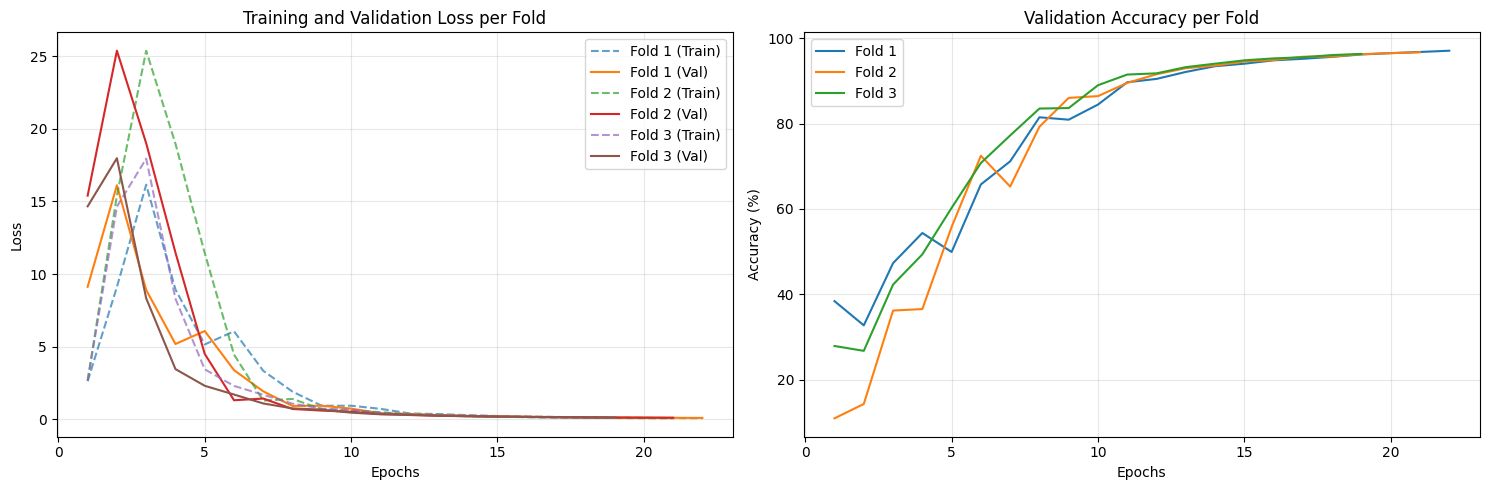


Trial 10 completed:
Parameters: {'n_neurons': (512, 256), 'eta_minus': 0.5, 'eta_plus': 1.2, 'min_step': 1e-07, 'max_step': 50.0}
Average accuracy across folds: 96.7343

Best trial results:
Parameters: {'n_neurons': (512, 256), 'eta_minus': 0.5, 'eta_plus': 1.2, 'min_step': 1e-07, 'max_step': 50.0}
Accuracy: 96.7343


In [5]:
seed = 42

set_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters for the random search
n_trials = 10

# Hyperparameters for the k-fold cross-validation
k_folds = 3

# Hyperparameters for the neural network
input_size = 28 * 28
num_classes = 10

# Hyperparameters for the training
num_epochs = 300
train_batch_size = None # degined after splitting the dataset (batch learning)
val_batch_size = None # defined after splitting the dataset (batch learning)
learning_rate = 0.01

# Hyperparameters for the Early Stopping
patience = 3
min_delta = 0.040

trial_results = []

param_space = {
    'n_neurons': [(128,), (128, 64), (256, 128), (384, 192), (512, 256)],
    'eta_minus': [0.7, 0.6, 0.5],
    'eta_plus': [1.4, 1.3, 1.2],
    'min_step': [1e-7, 1e-6, 1e-5],
    'max_step': [70, 60, 50]
}

for trial in range(n_trials):
    params = {
        'n_neurons': random.choice(param_space['n_neurons']),
        'eta_minus': float(np.random.choice(param_space['eta_minus'])),
        'eta_plus': float(np.random.choice(param_space['eta_plus'])),
        'min_step': float(np.random.choice(param_space['min_step'])),
        'max_step': float(np.random.choice(param_space['max_step']))
    }

    print(f"\nTrial {trial+1}/{n_trials}")
    print(f"Testing parameters: {params}")
    
    fold_train_losses = []
    fold_val_losses = []
    fold_val_accuracies = []
    
    dataset_targets = torch.cat([
        full_dataset.datasets[0].targets,
        full_dataset.datasets[1].targets
    ])
    
    kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
        
    for fold, (train_ids, val_ids) in enumerate(kfold.split(full_dataset, dataset_targets)):
        print(f'FOLD {fold+1}/{k_folds}')
        
        train_subset = torch.utils.data.Subset(full_dataset, train_ids)
        val_subset = torch.utils.data.Subset(full_dataset, val_ids)
        
        train_batch_size = len(train_subset)
        val_batch_size = len(val_subset)

        train_loader = create_dataloaders(train_subset, train_batch_size, num_workers=8, shuffle=True)
        val_loader = create_dataloaders(val_subset, val_batch_size, num_workers=8, shuffle=False)

        model, criterion, optimizer = create_model(
            input_size, params['n_neurons'], num_classes, 
            learning_rate, params['eta_minus'], params['eta_plus'], 
            params['min_step'], params['max_step'], device
        )
        
        train_losses, val_losses, val_accuracies = train_model(
            model, train_loader, val_loader, 
            criterion, optimizer, device, 
            num_epochs, patience, min_delta,
            verbose=False
        )

        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)
        fold_val_accuracies.append(val_accuracies)
    
    plot_fold_results(fold_train_losses, fold_val_losses, fold_val_accuracies)

    best_fold_accuracies = [max(acc_list) for acc_list in fold_val_accuracies]
    avg_accuracy = np.mean(best_fold_accuracies)
    trial_results.append((params, avg_accuracy))
    
    print(f"\nTrial {trial + 1} completed:")
    print(f"Parameters: {params}")
    print(f"Average accuracy across folds: {avg_accuracy:.4f}")

best_trial = max(trial_results, key=lambda x: x[1])
print("\nBest trial results:")
print(f"Parameters: {best_trial[0]}")
print(f"Accuracy: {best_trial[1]:.4f}")